In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [2]:
print(torch.cuda.current_device())  # The ID of the current GPU
print(torch.cuda.get_device_name(0))  # The name of the specified GPU
print(torch.cuda.device_count())  # The amount of GPUs that are accessible

0
Tesla P100-PCIE-12GB
1


In [3]:
torch.cuda.empty_cache()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [5]:
#Loading inr data we created while mnist training
path = "notebooks/dataset/mnist_splits.json"
statistics_path = "notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 4

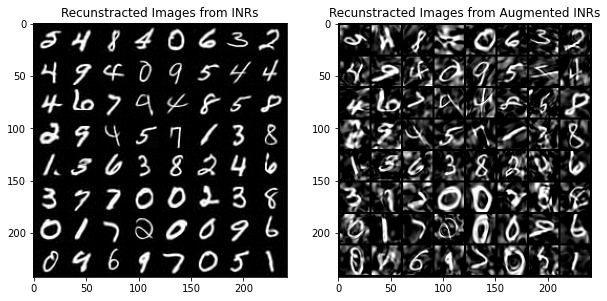

In [6]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt

dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [7]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)


train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

2024-07-17 15:54:59,492 - root - INFO - train size 55000, val size 5000, test size 10000


In [109]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU

#Our DWSModel equivalent to convolutional block of AutoEncoder which is used to build encoder/decoder layers
class DWSModel(nn.Module):
    def __init__(
            self,
            weight_shapes,
            bias_shapes,
            input_features,
            hidden_dims,
            n_hidden=2,
            output_features=None,
            reduction="max",
            bias=True,
            n_fc_layers=1,
            num_heads=8,
            set_layer="sab",
            input_dim_downsample=None,
            dropout_rate=0.0,
            add_skip=False,
            add_layer_skip=False,
            init_scale=1e-4,
            init_off_diag_scale_penalty=1.,
            bn=False,
            diagonal=False,
    ):
        super().__init__()
        assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
        assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"
        self.input_features = input_features
        self.input_dim_downsample = input_dim_downsample
        if output_features is None:
            output_features = hidden_dims[-1]

        self.add_skip = add_skip
        if self.add_skip:
            self.skip = nn.Linear(
                input_features,
                output_features,
                bias=bias
            )
            with torch.no_grad():
                torch.nn.init.constant_(self.skip.weight, 1. / self.skip.weight.numel())
                torch.nn.init.constant_(self.skip.bias, 0.)

        if input_dim_downsample is None:
            layers = [
                DWSLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features=input_features,
                    out_features=hidden_dims[0],
                    reduction=reduction,
                    bias=bias,
                    n_fc_layers=n_fc_layers,
                    num_heads=num_heads,
                    set_layer=set_layer,
                    add_skip=add_layer_skip,
                    init_scale=init_scale,
                    init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                    diagonal=diagonal,
                ),
            ]
            for i in range(n_hidden):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [

                        ReLU(),
                        Dropout(dropout_rate),
                        DWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1] if i != (n_hidden - 1) else output_features,
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads if i != (n_hidden - 1) else 1,
                            set_layer=set_layer,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        else:
            layers = [
                DownSampleDWSLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features=input_features,
                    out_features=hidden_dims[0],
                    reduction=reduction,
                    bias=bias,
                    n_fc_layers=n_fc_layers,
                    num_heads=num_heads,
                    set_layer=set_layer,
                    downsample_dim=input_dim_downsample,
                    add_skip=add_layer_skip,
                    init_scale=init_scale,
                    init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                    diagonal=diagonal,
                ),
            ]
            for i in range(n_hidden):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [
                        ReLU(),
                        Dropout(dropout_rate),
                        DownSampleDWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1] if i != (n_hidden - 1) else output_features,
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads if i != (n_hidden - 1) else 1,
                            set_layer=set_layer,
                            downsample_dim=input_dim_downsample,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        out = self.layers(x)
        if self.add_skip:
            skip_out = tuple(self.skip(w) for w in x[0]), tuple(
                self.skip(b) for b in x[1]
            )
            weight_out = tuple(ws + w for w, ws in zip(out[0], skip_out[0]))
            bias_out = tuple(bs + b for b, bs in zip(out[1], skip_out[1]))
            out = (weight_out, bias_out)
        return out

In [9]:
# from typing import Tuple
# from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU

# class DWSEncoder(nn.Module):
#     def __init__(
#             self,
#             weight_shapes,
#             bias_shapes,
#             input_features,
#             hidden_dims,
#             n_hidden=2,
#             output_features=None,
#             reduction="max",
#             bias=True,
#             n_fc_layers=1,
#             num_heads=8,
#             set_layer="sab",
#             input_dim_downsample=None,
#             dropout_rate=0.0,
#             add_skip=False,
#             add_layer_skip=False,
#             init_scale=1e-4,
#             init_off_diag_scale_penalty=1.,
#             bn=False,
#             diagonal=False,
#     ):
#         super().__init__()
#         assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
#         assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"
#         assert len(hidden_dims) == 2 , "One hidden dimension needed for DWSLayer and another of Invariant Layer"
#         self.input_features = input_features
#         self.hidden_dims = hidden_dims
#         self.input_dim_downsample = input_dim_downsample
#         self.weight_shapes = weight_shapes
#         self.bias_shapes = bias_shapes
#         if output_features is None:
#             output_features = hidden_dims[-1]

#         self.add_skip = add_skip
#         if self.add_skip:
#             self.skip = nn.Linear(
#                 input_features,
#                 output_features,
#                 bias=bias
#             )
#             with torch.no_grad():
#                 torch.nn.init.constant_(self.skip.weight, 1. / self.skip.weight.numel())
#                 torch.nn.init.constant_(self.skip.bias, 0.)

#         if input_dim_downsample is None:
#             layers = [
#                 DWSLayer(
#                     weight_shapes=weight_shapes,
#                     bias_shapes=bias_shapes,
#                     in_features=input_features,
#                     out_features=hidden_dims[0], #8
#                     reduction=reduction,
#                     bias=bias,
#                     n_fc_layers=n_fc_layers,
#                     num_heads=num_heads,
#                     set_layer=set_layer,
#                     add_skip=add_layer_skip,
#                     init_scale=init_scale,
#                     init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                     diagonal=diagonal,
#                 ),
#             ]

#         else:
#             layers = [
#                 DownSampleDWSLayer(
#                     weight_shapes=weight_shapes,
#                     bias_shapes=bias_shapes,
#                     in_features=input_features,
#                     out_features=hidden_dims[0],
#                     reduction=reduction,
#                     bias=bias,
#                     n_fc_layers=n_fc_layers,
#                     num_heads=num_heads,
#                     set_layer=set_layer,
#                     downsample_dim=input_dim_downsample,
#                     add_skip=add_layer_skip,
#                     init_scale=init_scale,
#                     init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                     diagonal=diagonal,
#                 ),
#             ]
        
#         if bn:
#             layers.append(BN(hidden_dims[0], len(weight_shapes), len(bias_shapes)))
        
#         layers.extend(
#             [
#                 ReLU(),
#                 Dropout(dropout_rate),
#                 InvariantLayer(
#                     weight_shapes=weight_shapes,
#                     bias_shapes=bias_shapes,
#                     in_features= hidden_dims[0],
#                     out_features=hidden_dims[1],
#                     reduction=reduction,
#                     n_fc_layers=3,
#                     ),
#                 ]
#             )

#         self.layers = nn.Sequential(*layers)

#     def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
#         out = self.layers(x)
#         if self.add_skip:
#             skip_out = tuple(self.skip(w) for w in x[0]), tuple(
#                 self.skip(b) for b in x[1]
#             )
#             weight_out = tuple(ws + w for w, ws in zip(out[0], skip_out[0]))
#             bias_out = tuple(bs + b for b, bs in zip(out[1], skip_out[1]))
#             out = (weight_out, bias_out)
#         return out

In [102]:
# from typing import Tuple
# from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU

# #Our DWSModel equivalent to convolutional block of AutoEncoder which is used to build encoder/decoder layers
# class DWSDecoder(nn.Module):
#     def __init__(
#             self,
#             weight_shapes,
#             bias_shapes,
#             input_features,
#             hidden_dims,
#             n_hidden=2,
#             output_features=None,
#             reduction="max",
#             bias=True,
#             n_fc_layers=1,
#             num_heads=8,
#             set_layer="sab",
#             input_dim_downsample=None,
#             dropout_rate=0.0,
#             add_skip=False,
#             add_layer_skip=False,
#             init_scale=1e-4,
#             init_off_diag_scale_penalty=1.,
#             bn=False,
#             diagonal=False,
#     ):
#         super().__init__()
#         assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
#         assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"
#         self.input_features = input_features
#         self.input_dim_downsample = input_dim_downsample
#         self.hidden_dims = hidden_dims
#         if output_features is None:
#             output_features = hidden_dims[-1]
#         self.weight_shapes = weight_shapes
#         self.bias_shapes = bias_shapes

#         layers = []
#         if input_dim_downsample is None:
#             layers.append( 
#                 DWSLayer(
#                         weight_shapes=weight_shapes,
#                         bias_shapes=bias_shapes,
#                         in_features= 32, 
#                         out_features= hidden_dims[1], 
#                         reduction=reduction,
#                         bias=bias,
#                         n_fc_layers=n_fc_layers,
#                         num_heads= num_heads,
#                         set_layer=set_layer,
#                         add_skip=add_layer_skip,
#                         init_scale=init_scale,
#                         init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                         diagonal=diagonal,
#                 ))
            
#             if bn:
#                 layers.append(BN(hidden_dims[1], len(weight_shapes), len(bias_shapes)))

#             layers.extend(
#                     [

#                     ReLU(),
#                     Dropout(dropout_rate),
#                     DWSLayer(
#                             weight_shapes=weight_shapes,
#                             bias_shapes=bias_shapes,
#                             in_features=hidden_dims[1], #8
#                             out_features=output_features,#1
#                             reduction=reduction,
#                             bias=bias,
#                             n_fc_layers=n_fc_layers,
#                             num_heads=1,
#                             set_layer=set_layer,
#                             add_skip=add_layer_skip,
#                             init_scale=init_scale,
#                             init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                             diagonal=diagonal,
#                     ),
#                 ]
#             )
#         else:
#             layers.append( 
#                 DownSampleDWSLayer(
#                         weight_shapes=weight_shapes,
#                         bias_shapes=bias_shapes,
#                         in_features= input_features, #2048
#                         out_features= hidden_dims[1], #8
#                         reduction=reduction,
#                         bias=bias,
#                         n_fc_layers=n_fc_layers,
#                         num_heads= num_heads,
#                         set_layer=set_layer,
#                         downsample_dim=input_dim_downsample,
#                         add_skip=add_layer_skip,
#                         init_scale=init_scale,
#                         init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                         diagonal=diagonal,
#                 ))
#             if bn:
#                 layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

#             layers.extend(
#                 [
#                     ReLU(),
#                     Dropout(dropout_rate),
#                     DownSampleDWSLayer(
#                         weight_shapes=weight_shapes,
#                         bias_shapes=bias_shapes,
#                         in_features=hidden_dims[0],
#                         out_features=output_features,
#                         reduction=reduction,
#                         bias=bias,
#                         n_fc_layers=n_fc_layers,
#                         num_heads= 1,
#                         set_layer=set_layer,
#                         downsample_dim=input_dim_downsample,
#                         add_skip=add_layer_skip,
#                         init_scale=init_scale,
#                         init_off_diag_scale_penalty=init_off_diag_scale_penalty,
#                         diagonal=diagonal,
#                     ),
#                 ]
#             )
#         self.layers = nn.Sequential(*layers)
        
#     def reconstruct_tensors(self, pooled_all: torch.Tensor):
#         weight_shapes = ((32,2), (32, 32), (32, 1))
#         bias_shapes = ((32,), (32,), (1,))
#         batch_size = pooled_all.shape[0]
#         input_features = 2
#         num_weights = len(weight_shapes)
#         num_biases = len(bias_shapes)

#         pooled_weights_size = sum([w[0] * w[1]*input_features for w in weight_shapes])
#         pooled_biases_size = sum([b[0]*input_features for b in bias_shapes])
#         pooled_weights = pooled_all[:, :pooled_weights_size]
#         pooled_biases = pooled_all[:, pooled_weights_size:pooled_weights_size + pooled_biases_size]

#         # Reconstruct weights
#         reconstructed_weights = []
#         start_idx = 0
#         for shape in weight_shapes:
#             size = shape[0] * shape[1] * input_features
#             pooled_w = pooled_weights[:, start_idx:start_idx + size]  # Shape: (batch_size, d_i * in_features)
#             pooled_w = pooled_w.view(batch_size,shape[0], shape[1], input_features,1)  # Reshape and permute back

#             # Approximate reconstruction (interpolation)
# #             reconstructed_w = F.interpolate(pooled_w, size=(shape[0], shape[1]), mode='nearest')

#             reconstructed_weights.append(pooled_w)
#             start_idx += size

#         # Reconstruct biases
#         reconstructed_biases = []
#         start_idx = 0
#         for shape in bias_shapes:
#             size = shape[0] * input_features
#             pooled_b = pooled_biases[:, start_idx:start_idx + size]  # Shape: (batch_size, d_i * in_features)
#             pooled_b = pooled_b.view(batch_size, shape[0], input_features,1)  # Reshape back
#             reconstructed_biases.append(pooled_b)
#             start_idx += size
#         return (tuple(reconstructed_weights), tuple(reconstructed_biases))
        
#     def forward(self, x):
#         weights, biases = self.reconstruct_tensors(x)
#         inputs= (weights, biases)
#         weight_shapes = tuple(w.shape[:2] for w in point.weights)
#         bias_shapes = tuple(b.shape[:1] for b in point.biases)
#         print(weight_shapes,bias_shapes)
#         out = self.layers(inputs)
#         if self.add_skip:
#             skip_out = tuple(self.skip(w) for w in x[0]), tuple(
#                 self.skip(b) for b in x[1]
#             )
#         weight_out = tuple(ws + w for w, ws in zip(out[0], skip_out[0]))
#         bias_out = tuple(bs + b for b, bs in zip(out[1], skip_out[1]))
#         out = (weight_out, bias_out)
#         return out

In [17]:
point = train_set.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [113]:
# Our AutoEncoder using DWSModel
class AutoEncoder(nn.Module):
    def __init__(
            self,
            input_features,
            weights_size,
            bias_size,
            hidden_dims,
            n_hidden=2,
            output_features=None,
            input_dim_downsample=None,
            add_skip=False,
            bn = False
    ):
        super().__init__()
        self.input_features = input_features
        self.weights_size = weights_size
        self.bias_size = bias_size
        self.input_dim_downsample = input_dim_downsample
        self.add_skip = add_skip
        self.n_hidden = n_hidden
        self.output_features = output_features
        self.hidden_dims = hidden_dims
        self.bn = bn
        self.encoder = DWSModel(weight_shapes=weights_size,
                                bias_shapes=bias_size,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                n_hidden=n_hidden,
                                bn=bn).to(device)
        self.decoder = DWSModel(weight_shapes=weights_size,
                                bias_shapes=bias_size,
                                input_features= hidden_dims[-1],
                                hidden_dims=hidden_dims[::-1],
                                output_features = input_features,
                                n_hidden=n_hidden,
                                bn=bn).to(device)
        
    def forward(self,inputs):
        weights1, biases1 = inputs
        weights1_tensors, biases1_tensors = [[torch.tensor(w, requires_grad=True) for w in x] for x in [weights1, biases1]]
        # Print the shapes of weights
        print("Shapes of weights1_tensors:")
        for i, weight in enumerate(weights1_tensors):
            print(f"Weight {i+1} shape: {weight.shape}")

        # Print the shapes of biases
        print("Shapes of biases1_tensors:")
        for i, bias in enumerate(biases1_tensors):
            print(f"Bias {i+1} shape: {bias.shape}")
        encoded_data = self.encoder(inputs)
        
    
        output = self.decoder(encoded_data)
        return output

In [21]:
# Custom loss function for tuples of tensors because our AutoEncoder gets tensors as output (not sure if this is the correct approach)
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.base_loss = nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        weights1_tensors, weights2_tensors, biases1_tensors, biases2_tensors = [[torch.tensor(w, requires_grad=True) for w in x] for x in [weights1, weights2, biases1, biases2]]
        total_loss = sum(self.base_loss(w1, w2) for w1, w2 in zip(weights1_tensors, weights2_tensors)) + \
             sum(self.base_loss(b1, b2) for b1, b2 in zip(biases1_tensors, biases2_tensors))

        return total_loss


In [18]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion =  TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += criterion(out, inputs)
        total += 1


    model.train()
    avg_loss = loss / total

    return avg_loss

In [19]:
from tqdm import trange
def train_model(model):
    learning_rate = 1e-3
    num_epochs = 20
    criterion =  TupleLoss()
    epoch_iter = trange(num_epochs)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    test_loss = -1
    for epoch in epoch_iter:
        for i, batch in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            batch = batch.to(device)
            
            inputs = (batch.weights, batch.biases)
            out = model(inputs)
            loss = criterion(out, inputs)
            loss.backward()
            optimizer.step()

            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test loss: {test_loss:.3f}"
            )
            test_loss =  evaluate(model, test_loader)
    
    

In [114]:
#Model with DWS Layers and No Batch Normalization
model = AutoEncoder(
    input_features=1, 
    weights_size = weight_shapes, 
    bias_size = bias_shapes,
    hidden_dims=[512,256],
    n_hidden=2,
    bn=False,
).to(device)
train_model(model)
torch.save(model.state_dict(), "Outputs/model.pth")

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-113-965c2f2ae388>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights1_tensors, biases1_tensors = [[torch.tensor(w, requires_grad=True) for w in x] for x in [weights1, biases1]]


Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32, 32, 1])
Weight 3 shape: torch.Size([32, 32, 1, 1])
Shapes of biases1_tensors:
Bias 1 shape: torch.Size([32, 32, 1])
Bias 2 shape: torch.Size([32, 32, 1])
Bias 3 shape: torch.Size([32, 1, 1])


<ipython-input-21-e29e65f1d556>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights1_tensors, weights2_tensors, biases1_tensors, biases2_tensors = [[torch.tensor(w, requires_grad=True) for w in x] for x in [weights1, weights2, biases1, biases2]]
[0 1], train loss: 6.711, test loss: -1.000:   0%|          | 0/20 [00:00<?, ?it/s]

Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32, 32, 1])
Weight 3 shape: torch.Size([32, 32, 1, 1])
Shapes of biases1_tensors:
Bias 1 shape: torch.Size([32, 32, 1])
Bias 2 shape: torch.Size([32, 32, 1])
Bias 3 shape: torch.Size([32, 1, 1])
Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32, 32, 1])
Weight 3 shape: torch.Size([32, 32, 1, 1])
Shapes of biases1_tensors:
Bias 1 shape: torch.Size([32, 32, 1])
Bias 2 shape: torch.Size([32, 32, 1])
Bias 3 shape: torch.Size([32, 1, 1])
Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32, 32, 1])
Weight 3 shape: torch.Size([32, 32, 1, 1])
Shapes of biases1_tensors:
Bias 1 shape: torch.Size([32, 32, 1])
Bias 2 shape: torch.Size([32, 32, 1])
Bias 3 shape: torch.Size([32, 1, 1])
Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32,

[0 1], train loss: 6.711, test loss: -1.000:   0%|          | 0/20 [00:04<?, ?it/s]

Shapes of weights1_tensors:
Weight 1 shape: torch.Size([32, 2, 32, 1])
Weight 2 shape: torch.Size([32, 32, 32, 1])
Weight 3 shape: torch.Size([32, 32, 1, 1])
Shapes of biases1_tensors:
Bias 1 shape: torch.Size([32, 32, 1])
Bias 2 shape: torch.Size([32, 32, 1])
Bias 3 shape: torch.Size([32, 1, 1])



Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/shared/centos7/anaconda3/2021.05/lib

KeyboardInterrupt: 

In [ ]:
#Model with DWS DownSample Layers
model2 = AutoEncoder(
    input_features=1,
    hidden_dims=[64,32],
    input_dim_downsample = 64,
    n_hidden=3,
    bn=False,
).to(device)
train_model(model2)
torch.save(model.state_dict(), "Outputs/model2.pth")

In [ ]:
#Model with DWSLayers and Batch Normalization
model3 = AutoEncoder(
    input_features=1,
    hidden_dims=[128,64,32],
    n_hidden=3,
    bn=True,
).to(device)
train_model(model3)